# Practical Work 4 - A little bit inside CNN..

## Introduction

Main goal: "see" how CNN learn, and experiment on several classical architectures the trained activations and weights

In [80]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [81]:
import tensorflow as tf
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
#from IPython.display import Image, display

from tensorflow.keras import backend as K

## Pretrained models
All Deep Learning Libraries provide classical architectures already trained on well known datasets ([ImageNet](http://www.image-net.org), [CIFAR](https://www.cs.toronto.edu/~kriz/cifar.html)...). Here we propose to use [VGG19](https://keras.io/api/applications/vgg/): see [publication](https://arxiv.org/abs/1409.1556)  . Once mastered, feel free to try another network such as:
- [DenseNet](https://keras.io/api/applications/densenet/): see the corresponding [publication](https://arxiv.org/abs/1608.06993)
- [ResNet](https://keras.io/api/applications/resnet/): see the corresponding [publication](https://arxiv.org/abs/1512.03385)
- [InceptionResNet](https://keras.io/api/applications/inceptionresnetv2/): see the corresponding [publication](https://arxiv.org/abs/1602.07261)
- [VGG16 or VGG19](https://keras.io/api/applications/vgg/): see the corresponding [publication](https://arxiv.org/abs/1409.1556)

or any other CNN already trained in Keras ([list](https://keras.io/api/applications/) of pretrained models)

In [82]:
##########################################
#VGG19
##########################################
from tensorflow.keras.applications.vgg19 import VGG19,preprocess_input
layers = [
    "block1_conv1",
    "block1_conv2",
    "block2_conv1",
    "block2_conv2",
    "block3_conv1",
    "block3_conv2",
    "block3_conv3",
    "block4_conv1",
    "block4_conv2",
    "block4_conv3",
    "block5_conv1",
    "block5_conv2",
    "block5_conv3",
]

We use the selected network trained on ImageNet

In [83]:
model = VGG19(weights='imagenet')
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Weights visualization
We first have a look at the trained weights. For the moment, we look at those of the first layer. 

If you change the network, take care of the number of kernels. Here, for VGG19, there are 64 kernels on layer 'block1_conv1' so we display 16*4 images

In [84]:
# Image normalization for display
def normalize(image):
    image = image.astype(np.float32)
    return (image - image.min()) / (image.max() - image.min()+1e-6)

# Tabular image display
def display_images(images, cols, titles=None):
  rows = (len(images)/cols)
  height_ratio = 1.2 * (rows/cols) * (0.5 if type(images[0]) is not np.ndarray else 1)
  plt.figure(figsize=(20, 20 * height_ratio))
  titles = titles or [""] * len(images)
  
  i = 1
  for image, title in zip(images, titles):
      plt.subplot(rows, cols, i)
      plt.axis("off")
      if type(image) is not np.ndarray:
          image = [normalize(g) for g in image]
          image = np.concatenate(image, axis=1)
      else:
          image = normalize(image)
      plt.title(title, fontsize=9)
      plt.imshow(image,cmap="Greys_r")
      i = i + 1

Get the weights of the first layer using [get_layer](https://keras.io/api/models/model/) method and output the result in the `weights` variable 

(3, 3, 3, 64)


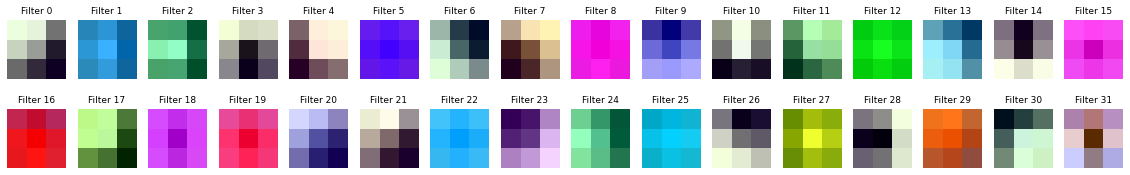

In [85]:
weights = model.get_layer(name=layers[0]).get_weights()[0]
print(weights.shape)
display_images([weights[:,:,::-1,i] for i in range(32)], cols=16,titles=['Filter '+str(i) for i in range(32)])

(3, 3, 64, 128)


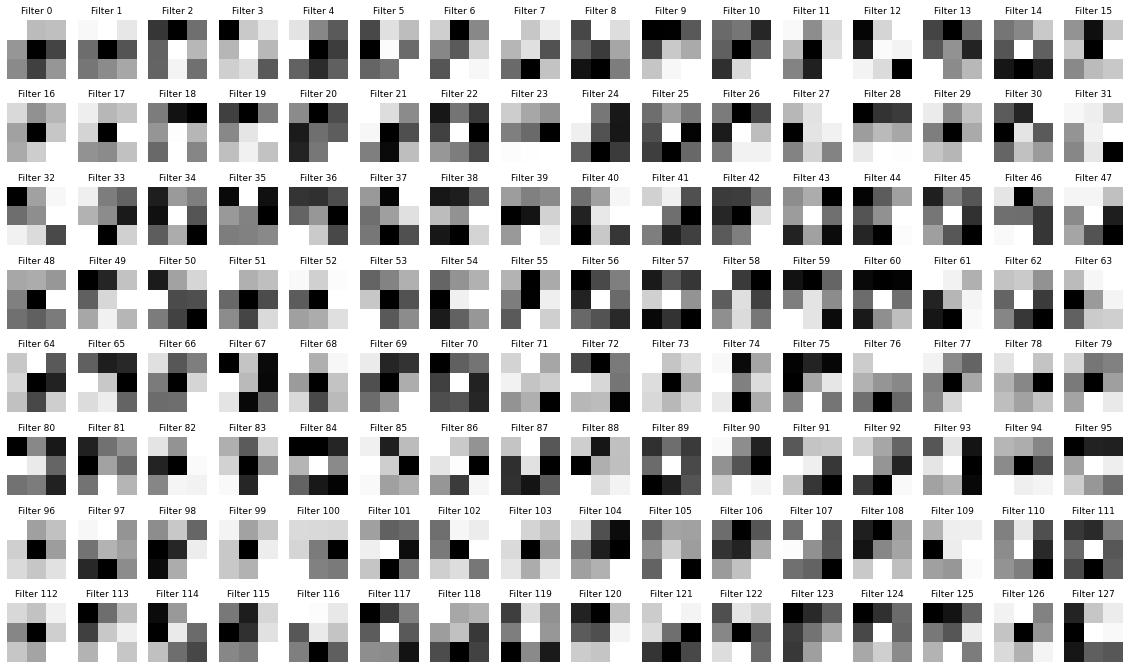

In [86]:
weights = model.get_layer(name=layers[2]).get_weights()[0]
print(weights.shape)
display_images([weights[:,:,0,i] for i in range(128)], cols=16,titles=['Filter '+str(i) for i in range(128)])

## Activations
We are now interested in the activations of the layers indicated in the `layers` variable. More specifically, we look at what neurons are activated across an image for each kernel type in a layer. In the first layers, some neurons are dedicated to edges or color detection. The deeper you go, the more complex features (and semantic) neurons capture, and not necesseraly localized but sparsely spread in the input image


In [87]:
# Allow an image to be the input of the network
def preprocess_image(img_path):
  img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
  img = tf.keras.preprocessing.image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = preprocess_input(img)
  return img

Here you can input your own image (for the next processings, the class of the image must be one of those described [here](https://www.kaggle.com/skyap79/imagenet-classes))

In [88]:
img_path = 'drive/MyDrive/Colab-Notebooks/Deep-Learning-Python/03-cnn-inside/cat.png'
img = preprocess_image(img_path)

In [89]:
def output_layer(model, img, layer_name):
    layer_output = K.function([model.layers[0].input], [model.get_layer(layer_name).output])
    outputs = layer_output([img])[0]
    return outputs[0]
    
def display_layer(model, img, layer_name, cols):
    outputs = output_layer(model, img, layer_name)
    display_images([outputs[:,:,i] for i in range(cols)], cols=cols,titles=[layer_name+'_'+str(i) for i in range(cols)])

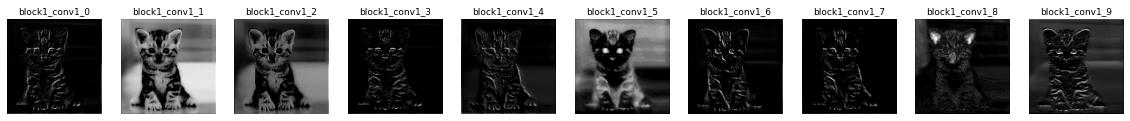

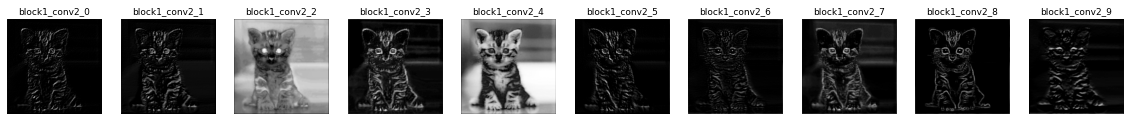

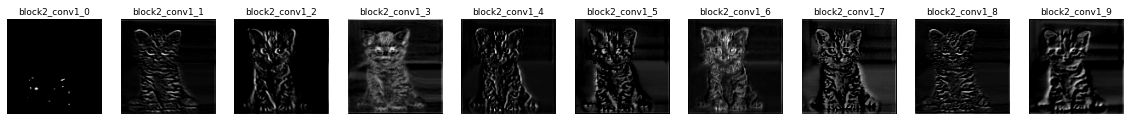

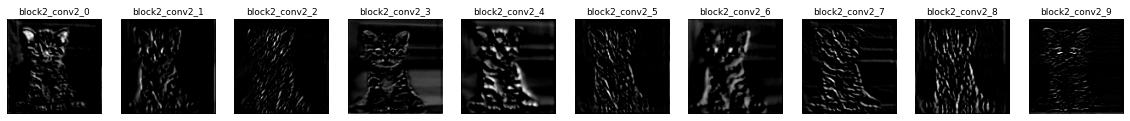

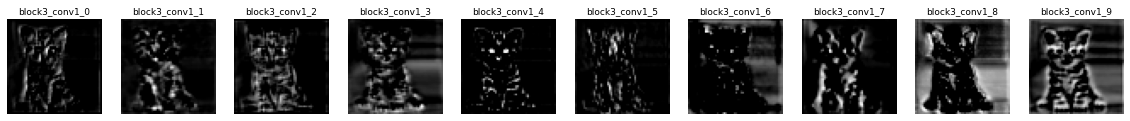

Error in callback <function flush_figures at 0x7fd6cd340290> (for post_execute):


KeyboardInterrupt: ignored

In [90]:
for layer_name in layers:
  outputs = output_layer(model, img, layer_name)
  display_layer(model, img, layer_name,cols=10)

In order to see what helped the CNN to find the "good" class, we can to overlap the last output layer to the original image. Highlighted areas will show important features for the class recognition

In [91]:
# Overlay of an image and a mask (filter or heatmap for gradcam, see below)
def overlay(img_path, map,alpha=0.4):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img = tf.keras.preprocessing.image.img_to_array(img)

    map = np.uint8(255 * map)

    # Colorize map with RBG values
    cmap = cm.get_cmap("jet")
    jet_colors = cmap(np.arange(256))[:, :3]
    colormap = jet_colors[map]

    # Create an image with RGB colorized heatmap
    colormap = tf.keras.preprocessing.image.array_to_img(colormap)
    colormap = colormap.resize((img.shape[1], img.shape[0]))
    colormap = tf.keras.preprocessing.image.img_to_array(colormap)

    # Superimpose the map on image
    overlay_img = img + colormap * alpha
    return (overlay_img)

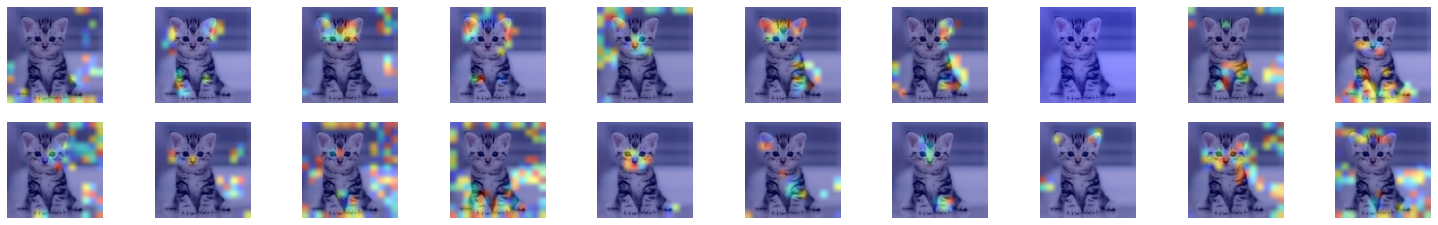

In [ ]:
from skimage.transform import resize
o = output_layer(model, img, layers[len(layers)-1])
image = np.array(tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224)))

n = 10
plt.figure(figsize=(26,6))
for i in range(2*n):
  plt.subplot(3,n,i+1)
  plt.axis('off')
  image_heatmap = overlay(img_path, o[:, :, i],  alpha=0.8)
  plt.imshow(normalize(image_heatmap))

Have a look at the results and try to find relevant parts exhibited by the last layer w.r.t to the output class

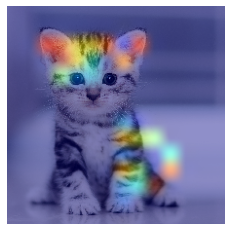

In [ ]:
plt.axis('off')
heatmap=overlay(img_path, o[:,:,5], alpha=0.8)
plt.imshow(normalize(heatmap))

##  GradCam
Among all techniques for visualizing where the netwok focuses on the input image, we implement [GradCam](https://arxiv.org/abs/1610.02391). The basic principle  is to take into account the spatial information preserved through the different layers of the CNN, in order to understand which parts of the input image were important for classification. More precisely, the method uses the gradient of the classification score with respect to the convolutional features determined by the network in order to understand the relevant parts that the CNN used for deciding the class of the input.


In [ ]:
def gradCam_heatmap(img, model, last_CL_name, pred_index=None):
    # Model : input -> activations of the last convolutional layer ->  output predictions
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_CL_name).output, model.output])

    # Gradient of the most probable class with respect to the activations of the last convolutional layer
    with tf.GradientTape() as tape:
        last_CL_output, preds = grad_model(img)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        mpclass = preds[:, pred_index]

    # Gradient of the output neuron with respect to the output feature map of the last convolutional layer
    grads = tape.gradient(mpclass, last_CL_output)

    # Mean intensity vector of the gradient over a specific feature map 
    mean_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Each channel is multiplied by its "importance" (w.r.t the predicted class) and channels are summed to produce the heatmap
    last_CL_output = last_CL_output[0]
    heatmap = last_CL_output @ mean_grads[..., tf.newaxis]
    return normalize(tf.squeeze(heatmap).numpy())

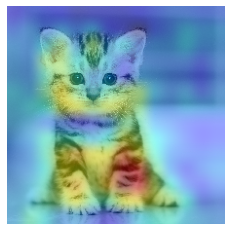

In [ ]:
# Remove softmax layer
model.layers[-1].activation = None
preds = model.predict(img)
heatmap = gradCam_heatmap(img, model, layers[len(layers)-1])
plt.imshow(normalize(overlay(img_path, heatmap,alpha=0.7)))
plt.axis('off');

GradCam is also applicable when several classes are present in the image

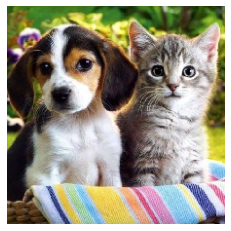

In [ ]:
catdog = 'drive/MyDrive/Colab-Notebooks/Deep-Learning-Python/03-cnn-inside/cd.png'
img = tf.keras.preprocessing.image.load_img(catdog, target_size=(224, 224))
plt.imshow(img)
plt.axis('off')

CAT = 282 ## See ImageNet class labels
DOG = 162

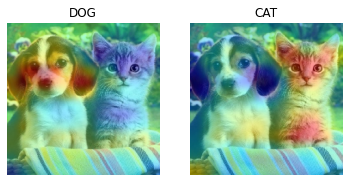

In [ ]:
img2 = preprocess_image(catdog)

plt.subplot(121)
heatmap = gradCam_heatmap(img2, model, layers[len(layers)-1], pred_index=DOG)
plt.imshow(normalize(overlay(catdog, heatmap,alpha=0.7)))
plt.axis('off')
plt.title("DOG")
plt.subplot(122)
heatmap = gradCam_heatmap(img2, model, layers[len(layers)-1], pred_index=CAT)
plt.imshow(normalize(overlay(catdog, heatmap,alpha=0.7)))
plt.axis('off')
plt.title("CAT");

## Occlusion sensitivity

We now reproduce the work of [Zeiler](http://arxiv.org/abs/1311.2901). We put  a small patch on the input image (occlusion), and see the response of the CNN. 

In [ ]:
def patch_image(image, x0, y0, patch_size):
    patched_image = np.array(image, copy=True)
    patched_image[y0:y0 + patch_size, x0:x0 + patch_size, :] = 127

    return patched_image

img_path = 'drive/MyDrive/Colab-Notebooks/Deep-Learning-Python/03-cnn-inside/dog.jpg'
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img = tf.keras.preprocessing.image.img_to_array(img)


CAT_CLASS_INDEX = CAT 
PATCH_SIZE = 10

sensitivity_map = np.zeros((img.shape[0], img.shape[1]))

# Iterate the patch over the image
for x in range(0, img.shape[0], PATCH_SIZE):
    for y in range(0, img.shape[1], PATCH_SIZE):
        patch = patch_image(img, x, y, PATCH_SIZE)
        predicted_classes = model.predict(np.array([patch]))[0]
        confidence = predicted_classes[CAT_CLASS_INDEX]
        
        # Save confidence for this specific patched image in map
        sensitivity_map[
            y:y + PATCH_SIZE,
            x:x + PATCH_SIZE,
        ] = confidence


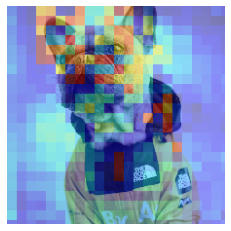

In [ ]:
plt.imshow(normalize(overlay(img_path, sensitivity_map,alpha=0.7)))
plt.axis('off');

Experiment with your own images (class lables of ImageNet : https://www.kaggle.com/skyap79/imagenet-classes)

# Reconstruction of inputs using activations

Finally, we will use the layer activations to reconstruct images. Starting with a white noise image, we optimize the neurons activation across each layer to be as close as possible to the activation of the original image.

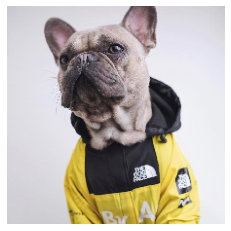

In [ ]:
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
plt.imshow(img)
plt.axis('off')
img= np.array(img)

In [ ]:
def gradient_descent_step(input_data, correct_output, incmodel, optimizer):
    with tf.GradientTape() as tape:
        tape.watch(input_data)
        # model output 
        outputs = incmodel(input_data)
        # gradients
        grads = tape.gradient(tf.reduce_mean(tf.math.square(correct_output - outputs)), input_data)
        # optimization
        optimizer.apply_gradients(zip([grads], [input_data]))
        # clip data
        input_data.assign(tf.clip_by_value(input_data, 0, 1))
    return input_data

In [ ]:
#Redefinition of layers to be displayed (adding last layers if needed)
if ( layers[len(layers)-1] != "predictions"):
  layers.append("fc1")
  layers.append("fc2")
  layers.append("predictions")

#Reload model (the softmax layer has been suppressed for gradCam)
model = VGG19(weights='imagenet')

layer_imgs = []
nbsteps = 1000
lr=5e-2
for layer_name in (layers):
    print("Processing ",layer_name)
    # model input->layer_name output
    incmodel = tf.keras.models.Model([model.inputs[0]], [model.get_layer(layer_name).output])
    # Image reconstruction, starting from a noise image
    noise = tf.cast(tf.random.uniform((1, 224, 224, 3)),tf.float32)
    data = tf.Variable(noise)

    correct_output = incmodel(tf.expand_dims(img[:,:,::-1],0))
    optimizer = tf.keras.optimizers.Adam(lr)
    for i in np.arange(nbsteps):
        data = gradient_descent_step(data, correct_output, incmodel, optimizer)
    res = np.squeeze(data.numpy())
    layer_imgs.append((layer_name, np.squeeze(res)[:, :, ::-1]))

#Display    
ncols = 4
nrows = int(len(layer_imgs) / ncols)
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*4, nrows*4))
for lii, (ln, li) in enumerate(layer_imgs):
    ax = axs.flatten()[lii]
    ax.set_title(ln)
    ax.imshow(li)
    ax.axis('off')